# Healthcare Decision Support System


<p><center>
<img src="https://www.opentext.com/assets/images/products-solutions/solution-industry-category/opentext-image-ov-healthcare-en.jpg" style="width:500px"> <br>
</center></p>
A Healthcare Decision Support System (HDSS) leverages technology to analyze healthcare data, providing professionals with insights for informed decision-making in patient care, treatment planning, and resource management. This project enhances an HDSS using a machine learning classifier model. By analyzing patient data and predicting outcomes, this system aims to optimize clinical decisions, improve patient outcomes, and streamline healthcare delivery through personalized recommendations and assessments.



In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

In [7]:
drug = pd.read_csv('drug200.csv')
drug

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [8]:
drug.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [9]:
drug.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [10]:
drug.duplicated().sum()

0

In [11]:
drug.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


### Visualizing Data Distributions

Boxplots help healthcare professionals quickly grasp variability, central tendency, and outliers in patient data attributes and assess model performance across different patient groups or scenarios, supporting informed decision-making in healthcare.



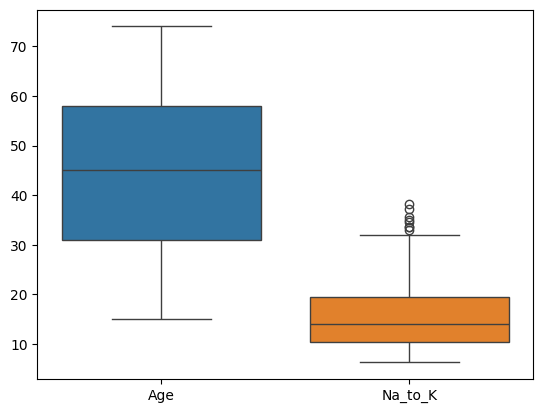

In [12]:
sns.boxplot(drug)
plt.show()

### Understanding Relationships and Implications

Correlation aids in identifying associations, here It does not imply causation. This distinction is crucial for informed decision-making in healthcare, guiding interventions, resource allocation, and further research efforts based on empirical data insights.

In [13]:
column1 = drug['Age']
column2 = drug['Na_to_K']
new_drug = pd.DataFrame({
    'Age': column1,
    'Na_to_K': column2
})

new_drug.corr()

,Age,Na_to_K
Age,1.000000,-0.063119
Na_to_K,-0.063119,1.000000


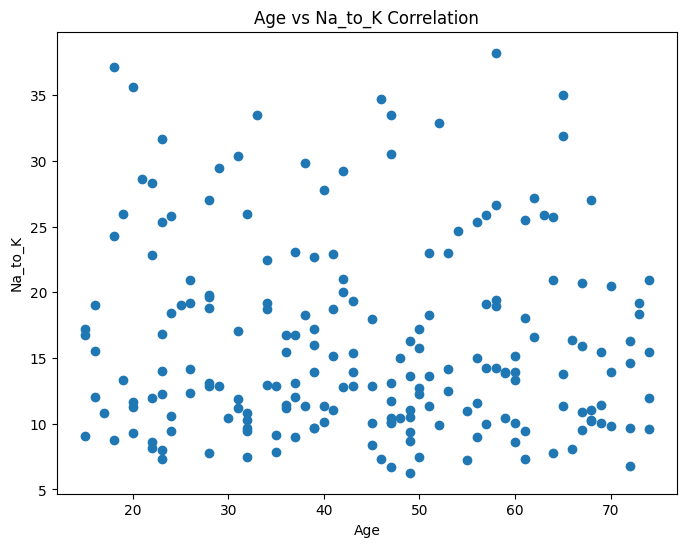

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(drug['Age'], drug['Na_to_K'])
plt.title('Age vs Na_to_K Correlation')
plt.xlabel('Age')
plt.ylabel('Na_to_K')
plt.show()

### Visualizing Data Trends

This clarity helps healthcare professionals quickly identify patterns, assess patient demographics, and make data-driven decisions, though careful consideration of bin size and distribution shape is crucial for accurate interpretation in clinical settings.

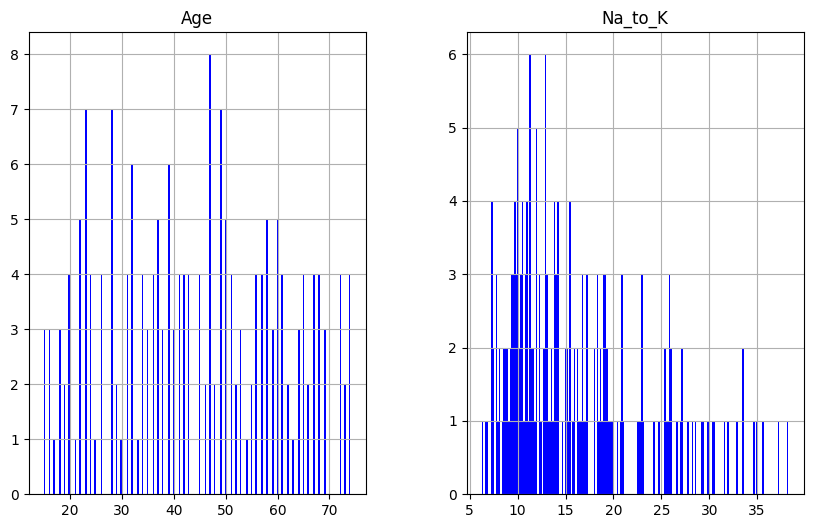

In [15]:
drug.hist(bins = 200, figsize = (10,6), color = 'b')
plt.show()

### Exploring Patient Profiles                                                                              
Adults comprise about half of all patients, emphasizing their significant presence in the healthcare system. This visual representation clarifies demographic proportions, informing targeted healthcare strategies and resource allocation.

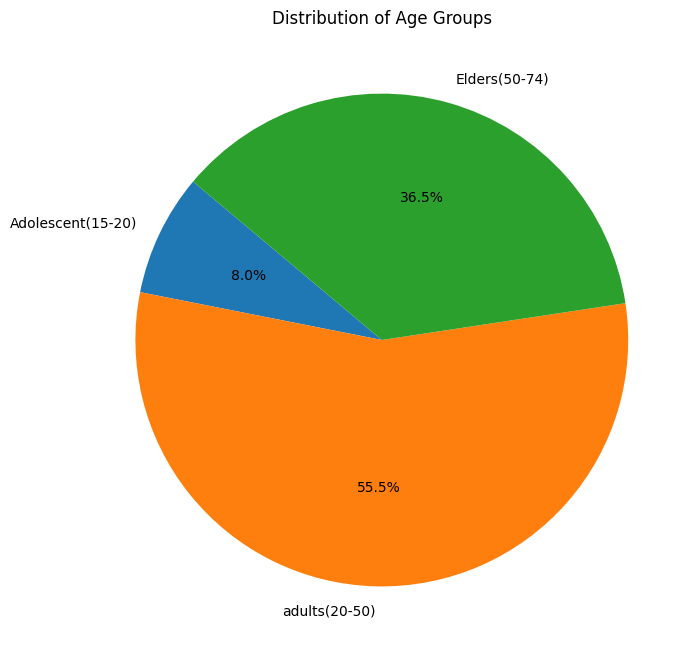

In [16]:
bins = [drug['Age'].min(), 20, 50, drug['Age'].max()]
labels = ['Adolescent(15-20)', 'adults(20-50)', 'Elders(50-74)']
drug['AgeGroup'] = pd.cut(drug['Age'], bins=bins, labels=labels, include_lowest=True)

Age_group_counts = drug['AgeGroup'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(Age_group_counts, labels=Age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Age Groups')
plt.show()

### Drugs Effect on Blood Pressure

The highest percentage for HIGH BP, suggesting a significant impact of medications on raising blood pressure. However, the close percentages for HIGH BP, MEDIUM BP, and LOW BP indicate varying degrees of influence across medications, emphasizing the complexity in managing their effects on blood pressure levels.

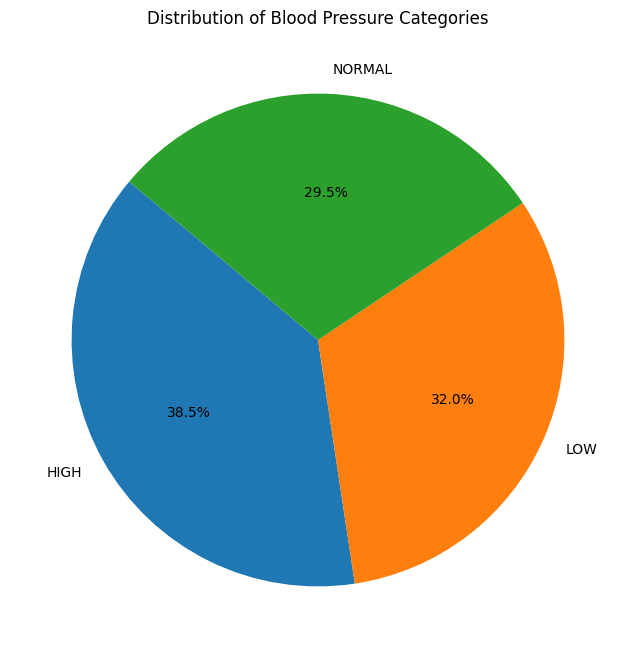

In [17]:
bp_counts = drug['BP'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(bp_counts, labels=bp_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Blood Pressure Categories')
plt.show()

### Comparing Drug Responses in Blood Pressure Management

DrugA and DrugB consistently induce high blood pressure (BP), making them unsuitable for BP patients. In contrast, DrugC reliably lowers BP levels, making it beneficial for reducing hypertension. DrugY affects BP differently, with 60% of patients experiencing normal BP, 20% high BP, and another 20% low BP. Meanwhile, DrugX is notably effective in maintaining normal BP levels in 66% of cases. These varying effects highlight the importance of selecting medications tailored to individual BP needs and responses

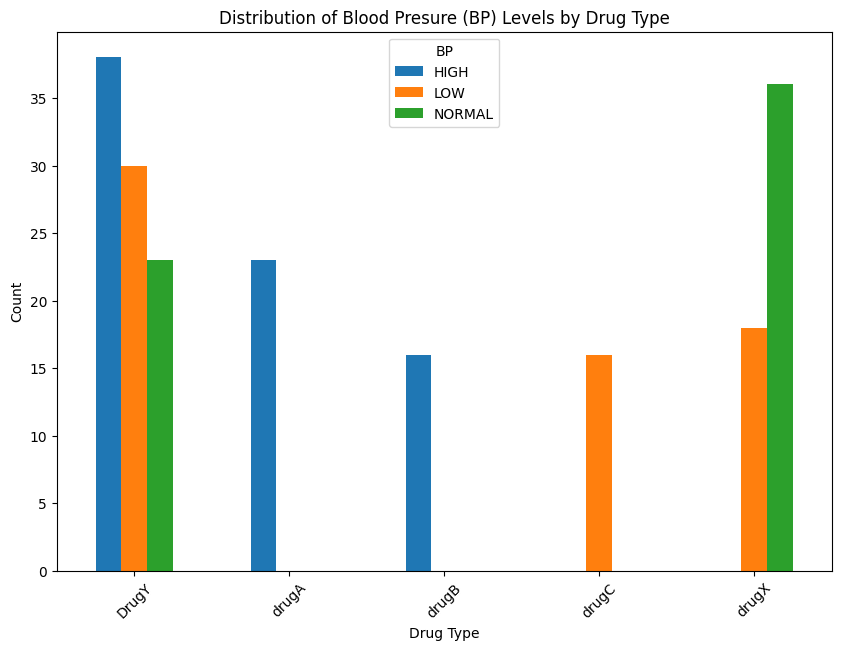

In [18]:
BP_drug_counts = pd.crosstab(drug['Drug'], drug['BP'])
BP_drug_counts.plot(kind='bar', figsize=(10, 7))
plt.title('Distribution of Blood Presure (BP) Levels by Drug Type')
plt.xlabel('Drug Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Drugs Effect on Cholesterol Levels

DrugC consistently raises cholesterol levels, which may not be suitable for patients with cholesterol-related conditions. Similarly, DrugB exhibits a similar effect, which complicates treatment decisions. DrugA and DrugY have comparable effects, impacting cholesterol levels similarly. On the other hand, DrugX results in normal cholesterol levels in nearly 37% of cases. This dichotomy between high and normal cholesterol outcomes underscores the importance of selecting medications carefully based on their specific effects on cholesterol levels, ensuring optimal management of cholesterol-related health conditions.

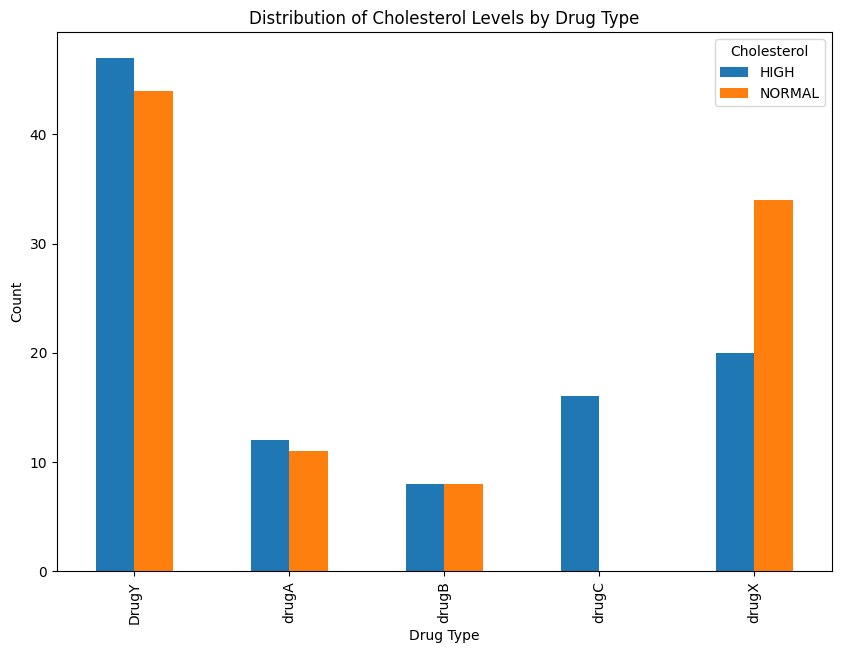

In [19]:
cholesterol_drug_counts = pd.crosstab(drug['Drug'], drug['Cholesterol'])
cholesterol_drug_counts.plot(kind='bar', figsize=(10, 7))
plt.title('Distribution of Cholesterol Levels by Drug Type')
plt.xlabel('Drug Type')
plt.ylabel('Count')
plt.show()

### From Limited Data to High Performance

Data augmentation is essential in machine learning for improving model performance and generalization by creating diverse variations of existing data. It reduces overfitting, enhances robustness, and balances class distributions, especially when data is limited. In healthcare decision support systems, it ensures models are accurate and reliable, effectively handling diverse clinical data.

In [20]:
def augment_data(df, num_samples=1000):
    augmented_data = []
    for _ in range(num_samples):
        sample = df.sample(n=1)
        augmented_sample = sample.copy()
        augmented_data.append(augmented_sample)
    return pd.concat(augmented_data, ignore_index=True)

augmented_data = augment_data(drug, num_samples=1000)

print("Original Data Shape:", drug.shape)
print("Augmented Data Shape:", augmented_data.shape)
print(augmented_data.head())

Original Data Shape: (200, 7)
Augmented Data Shape: (1000, 7)
   Age Sex      BP Cholesterol  Na_to_K   Drug       AgeGroup
0   68   F    HIGH      NORMAL   10.189  drugB  Elders(50-74)
1   22   M  NORMAL        HIGH   11.953  drugX  adults(20-50)
2   32   F    HIGH      NORMAL   25.974  DrugY  adults(20-50)
3   41   F  NORMAL      NORMAL   22.905  DrugY  adults(20-50)
4   47   M     LOW      NORMAL   33.542  DrugY  adults(20-50)


### Predictive Modeling

Use data-driven insights to improve clinical decision-making, predict patient outcomes, recommend treatments, and optimize healthcare delivery.

In [ ]:
pip install lazypredict

In [22]:
import lazypredict

In [23]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer

In [ ]:
X = drug[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug']]
y = drug['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

### From Data to Decisions

Effective healthcare decision-making relies increasingly on advanced machine learning algorithms. This study aims to optimize clinical insights, predict patient outcomes, and personalize treatment recommendations. This explores how the model transforms healthcare decision support systems, enhancing both efficiency and patient care.

In [25]:
drug['Sex'] = LabelEncoder().fit_transform(drug['Sex'])
drug['BP'] = LabelEncoder().fit_transform(drug['BP'])
drug['Cholesterol'] = LabelEncoder().fit_transform(drug['Cholesterol'])

X = drug[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = drug['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

perceptron = Perceptron(random_state=123)

param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'eta0': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Best Parameters: {'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 1000, 'penalty': None, 'tol': 0.0001}
Accuracy: 0.88
              precision    recall  f1-score   support

       DrugY       0.98      0.90      0.94        51
       drugA       1.00      0.50      0.67        12
       drugB       0.67      1.00      0.80         8
       drugC       0.62      1.00      0.77         5
       drugX       0.85      0.96      0.90        24

    accuracy                           0.88       100
   macro avg       0.82      0.87      0.82       100
weighted avg       0.91      0.88      0.88       100



### Final Frontier

Following substantial improvements in model accuracy, healthcare decision support systems are poised for transformative advancements. This study enhances predictive precision and personalized treatment recommendations and empowering clinicians with precise data-driven insights to make informed decisions swiftly and effectively.

In [26]:
X = drug[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = drug['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

perceptron = Perceptron(random_state=123)

rfecv = RFECV(estimator=perceptron, step=1, cv=5, scoring='accuracy', n_jobs=-1)
X_train_rfecv = rfecv.fit_transform(X_train, y_train)

selected_features = X.columns[rfecv.support_]

print("Selected features:", selected_features)

perceptron.fit(X_train_rfecv, y_train)

X_test_rfecv = X_test[:, rfecv.support_]

y_pred = perceptron.predict(X_test_rfecv)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Selected features: Index(['Age', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')
Accuracy: 0.92
              precision    recall  f1-score   support

       DrugY       0.91      0.98      0.94        51
       drugA       1.00      0.83      0.91        12
       drugB       0.80      1.00      0.89         8
       drugC       1.00      0.60      0.75         5
       drugX       0.95      0.88      0.91        24

    accuracy                           0.92       100
   macro avg       0.93      0.86      0.88       100
weighted avg       0.93      0.92      0.92       100



## The first wealth is health.

<img src="https://2759869.fs1.hubspotusercontent-na1.net/hubfs/2759869/happyhealthcareworkers-1.jpg" style="width:500px"> <br></center></p>